In [1]:
import ast
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import tensorflow as tf
import tensorflow.keras.backend as K
import warnings
warnings.filterwarnings('ignore')

from collections import Counter
from random import randint, random
from scipy.sparse import coo_matrix, hstack
from sklearn.metrics.pairwise import euclidean_distances, cosine_distances, cosine_similarity
from tensorflow import keras
from tqdm import tqdm

## Считаем препроцессные данные из прошлого ноутбучка

In [2]:
interactions_df = pd.read_csv('data_original/interactions_processed_kion.csv')
users_df = pd.read_csv('data_original/users_processed_kion.csv')
items_df = pd.read_csv('data_original/items_processed_kion.csv')

In [3]:
users_df.head()

,user_id,age,income,sex,kids_flg
0,973171,age_25_34,income_60_90,M,True
1,962099,age_18_24,income_20_40,M,False
2,1047345,age_45_54,income_40_60,F,False
3,721985,age_45_54,income_20_40,F,False
4,704055,age_35_44,income_60_90,F,False


In [4]:
items_df = items_df.rename(columns = {'id' : 'item_id'})

In [5]:
items_df.head()

,item_id,content_type,title,title_orig,genres,countries,for_kids,age_rating,studios,directors,actors,description,keywords,release_year_cat
0,10711,film,поговори с ней,Hable con ella,"драмы, зарубежные, детективы, мелодрамы",испания,False,16.0,unknown,педро альмодовар,"Адольфо Фернандес, Ана Фернандес, Дарио Гранди...",Мелодрама легендарного Педро Альмодовара «Пого...,"Поговори, ней, 2002, Испания, друзья, любовь, ...",2000-2010
1,2508,film,голые перцы,Search Party,"зарубежные, приключения, комедии",сша,False,16.0,unknown,скот армстронг,"Адам Палли, Брайан Хаски, Дж.Б. Смув, Джейсон ...",Уморительная современная комедия на популярную...,"Голые, перцы, 2014, США, друзья, свадьбы, прео...",2010-2020
2,10716,film,тактическая сила,Tactical Force,"криминал, зарубежные, триллеры, боевики, комедии",канада,False,16.0,unknown,адам п. калтраро,"Адриан Холмс, Даррен Шалави, Джерри Вассерман,...",Профессиональный рестлер Стив Остин («Все или ...,"Тактическая, сила, 2011, Канада, бандиты, ганг...",2010-2020
3,7868,film,45 лет,45 Years,"драмы, зарубежные, мелодрамы",великобритания,False,16.0,unknown,эндрю хэй,"Александра Риддлстон-Барретт, Джеральдин Джейм...","Шарлотта Рэмплинг, Том Кортни, Джеральдин Джей...","45, лет, 2015, Великобритания, брак, жизнь, лю...",2010-2020
4,16268,film,все решает мгновение,None,"драмы, спорт, советские, мелодрамы",ссср,False,12.0,ленфильм,виктор садовский,"Александр Абдулов, Александр Демьяненко, Алекс...",Расчетливая чаровница из советского кинохита «...,"Все, решает, мгновение, 1978, СССР, сильные, ж...",1970-1980


In [6]:
interactions_df.head()

,user_id,item_id,last_watch_dt,total_dur,watched_pct
0,176549,9506,2021-05-11,4250,72
1,699317,1659,2021-05-29,8317,100
2,656683,7107,2021-05-09,10,0
3,864613,7638,2021-07-05,14483,100
4,964868,9506,2021-04-30,6725,100


## Готовим фичи пользователей

Посмотрим, какие фичи в датасете фильмов являются категориальными и закодируем их с помощью one-hot encoding.

In [7]:
user_cat_feats = ["age", "income", "sex", "kids_flg"]
# из исходного датафрейма оставим только item_id - этот признак нам понадобится позже
# для того, чтобы маппить айтемы из датафрейма с фильмами с айтемами 
# из датафрейма с взаимодействиями
users_ohe_df = users_df.user_id
for feat in user_cat_feats:
    # получаем датафрейм с one-hot encoding для каждой категориальной фичи
    ohe_feat_df = pd.get_dummies(users_df[feat], prefix=feat)
    # конкатенируем ohe-hot датафрейм с датафреймом, 
    # который мы получили на предыдущем шаге
    users_ohe_df = pd.concat([users_ohe_df, ohe_feat_df], axis=1)

users_ohe_df.head()


,user_id,age_age_18_24,age_age_25_34,age_age_35_44,age_age_45_54,age_age_55_64,age_age_65_inf,age_age_unknown,income_income_0_20,income_income_150_inf,income_income_20_40,income_income_40_60,income_income_60_90,income_income_90_150,income_income_unknown,sex_F,sex_M,sex_sex_unknown,kids_flg_False,kids_flg_True
0,973171,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1
1,962099,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0
2,1047345,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0
3,721985,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0
4,704055,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0


## Готовим фичи айтемов

Кодируем их точно так же - one-hot'ом.

In [8]:
items_df.head()

,item_id,content_type,title,title_orig,genres,countries,for_kids,age_rating,studios,directors,actors,description,keywords,release_year_cat
0,10711,film,поговори с ней,Hable con ella,"драмы, зарубежные, детективы, мелодрамы",испания,False,16.0,unknown,педро альмодовар,"Адольфо Фернандес, Ана Фернандес, Дарио Гранди...",Мелодрама легендарного Педро Альмодовара «Пого...,"Поговори, ней, 2002, Испания, друзья, любовь, ...",2000-2010
1,2508,film,голые перцы,Search Party,"зарубежные, приключения, комедии",сша,False,16.0,unknown,скот армстронг,"Адам Палли, Брайан Хаски, Дж.Б. Смув, Джейсон ...",Уморительная современная комедия на популярную...,"Голые, перцы, 2014, США, друзья, свадьбы, прео...",2010-2020
2,10716,film,тактическая сила,Tactical Force,"криминал, зарубежные, триллеры, боевики, комедии",канада,False,16.0,unknown,адам п. калтраро,"Адриан Холмс, Даррен Шалави, Джерри Вассерман,...",Профессиональный рестлер Стив Остин («Все или ...,"Тактическая, сила, 2011, Канада, бандиты, ганг...",2010-2020
3,7868,film,45 лет,45 Years,"драмы, зарубежные, мелодрамы",великобритания,False,16.0,unknown,эндрю хэй,"Александра Риддлстон-Барретт, Джеральдин Джейм...","Шарлотта Рэмплинг, Том Кортни, Джеральдин Джей...","45, лет, 2015, Великобритания, брак, жизнь, лю...",2010-2020
4,16268,film,все решает мгновение,None,"драмы, спорт, советские, мелодрамы",ссср,False,12.0,ленфильм,виктор садовский,"Александр Абдулов, Александр Демьяненко, Алекс...",Расчетливая чаровница из советского кинохита «...,"Все, решает, мгновение, 1978, СССР, сильные, ж...",1970-1980


In [9]:
item_cat_feats = ['content_type', 'release_year_cat',
                  'for_kids', 'age_rating', 
                  'studios', 'countries', 'directors']

items_ohe_df = items_df.item_id

for feat in item_cat_feats:
    ohe_feat_df = pd.get_dummies(items_df[feat], prefix=feat)
    items_ohe_df = pd.concat([items_ohe_df, ohe_feat_df], axis=1) 

items_ohe_df.head()

,item_id,content_type_film,content_type_series,release_year_cat_1920-1930,release_year_cat_1930-1940,release_year_cat_1940-1950,release_year_cat_1950-1960,release_year_cat_1960-1970,release_year_cat_1970-1980,release_year_cat_1980-1990,...,directors_ярив хоровиц,directors_ярон зильберман,directors_ярополк лапшин,directors_ярослав лупий,"directors_ярроу чейни, скотт моужер",directors_ясина сезар,directors_ясуоми умэцу,"directors_ёдзи фукуяма, ацуко фукусима, николас де креси, синъитиро ватанабэ, сёдзи кавамори",directors_ёлкин туйчиев,directors_ён сан-хо
0,10711,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2508,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,10716,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,7868,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,16268,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


# HW 1.2 Добавить текстовые признаки в модель. (3 балла)

### Добавим текстовое описание как признак, для этого будем использовать fasttext эмбеддинги с пониженной размерностью до 10

In [10]:
# !wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.ru.300.vec.gz
# !gzip -d cc.ru.300.vec.gz

In [11]:
from nltk.tokenize import word_tokenize, wordpunct_tokenize
from tqdm import tqdm
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA

In [12]:
def process_text(text):
    
    words = wordpunct_tokenize(text.lower())
    
    return words

In [13]:
word2freq = {}
lengths = []

for text in tqdm(items_df["description"]):
    
    words = process_text(text)
    
    lengths.append(len(words))
    
    for word in words:
        
        if word in word2freq:
            word2freq[word] += 1
        else:
            word2freq[word] = 1

  0%|          | 0/15963 [00:00<?, ?it/s]

100%|██████████| 15963/15963 [00:00<00:00, 23785.49it/s]


<Axes: title={'center': 'Распределение длин слов в текстах'}, xlabel='Длина предложения', ylabel='Доля'>

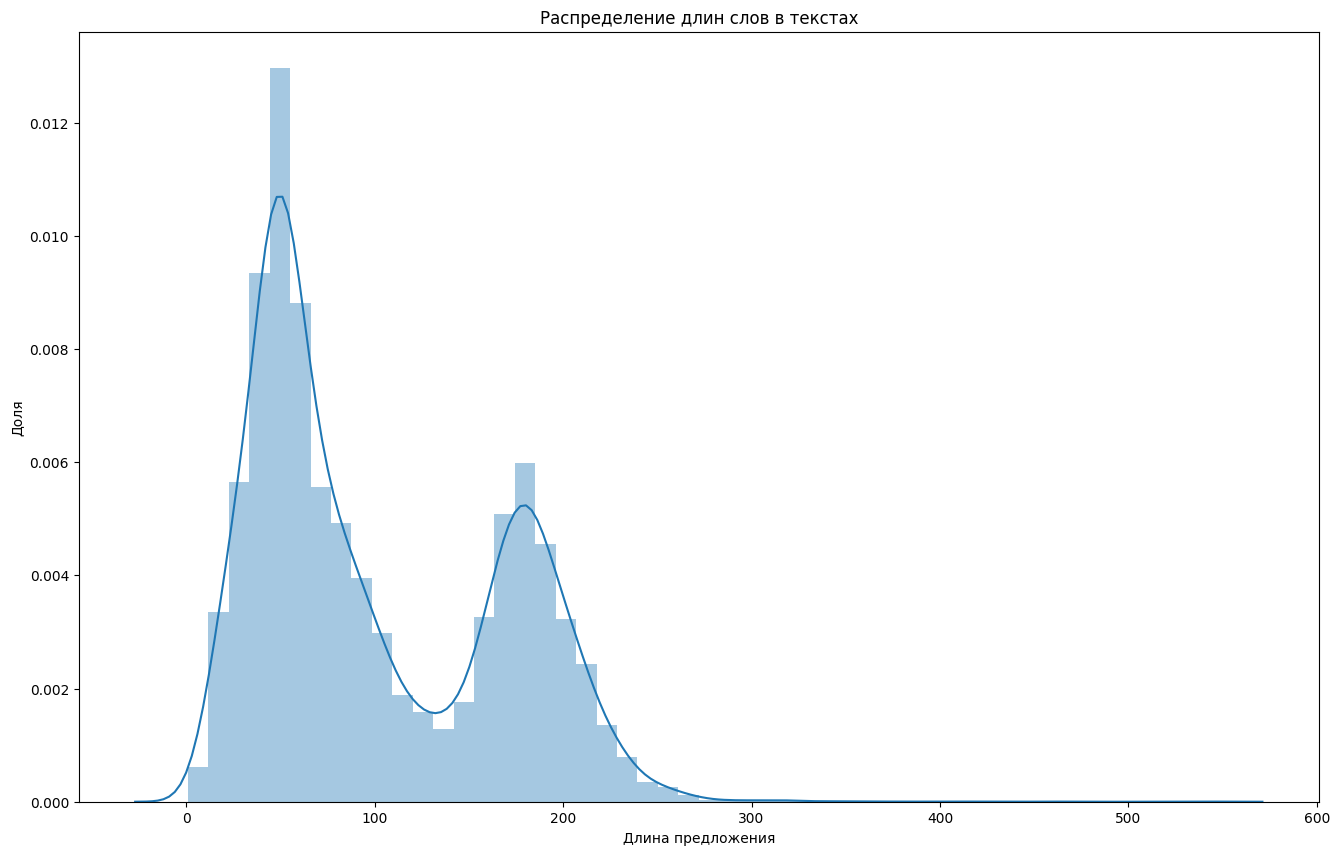

In [14]:
plt.figure(figsize=(16, 10))
plt.title('Распределение длин слов в текстах')
plt.xlabel('Длина предложения')
plt.ylabel('Доля')
sns.distplot(lengths)

In [15]:
word2index = {'PAD': 0}
vectors = []
    
word2vec_file = open('cc.ru.300.vec')
    
n_words, embedding_dim = word2vec_file.readline().split()
n_words, embedding_dim = int(n_words), int(embedding_dim)

# Zero vector for PAD
vectors.append(np.zeros((1, embedding_dim)))

progress_bar = tqdm(desc='Read word2vec', total=n_words)

while True:

    line = word2vec_file.readline().strip()

    if not line:
        break
        
    current_parts = line.split()

    current_word = ' '.join(current_parts[:-embedding_dim])

    if current_word in word2freq:

        word2index[current_word] = len(word2index)

        current_vectors = current_parts[-embedding_dim:]
        current_vectors = np.array(list(map(float, current_vectors)))
        current_vectors = np.expand_dims(current_vectors, 0)

        vectors.append(current_vectors)

    progress_bar.update(1)

progress_bar.close()

word2vec_file.close()

vectors = np.concatenate(vectors)

Read word2vec: 100%|██████████| 2000000/2000000 [00:32<00:00, 61697.93it/s]


In [16]:
pca = PCA(n_components=10)
word_embedding_reduced = pca.fit_transform(vectors)

#### Тут мы получаем эмбеддинг предложения как сумму эмбеддингов слов

In [17]:
def get_sentence_embedding(text):
    text = process_text(text)
    indexed_text = [word2index[word] for word in text if word in word2index]
    sentence_embs = np.sum(word_embedding_reduced[indexed_text], axis=0)
    
    if len(sentence_embs) < 10:
        sentence_embs = sentence_embs.resize(10)
    
    return sentence_embs

In [18]:
embeddings = pd.DataFrame()

In [19]:
embeddings['embs'] = items_df["description"].apply(lambda x: get_sentence_embedding(x))
sent_embs = pd.DataFrame(embeddings['embs'].to_list(), columns=['wv1', 'wv2', 'wv3', 'wv4', 'wv5', 'wv6', 'wv7', 'wv8', 'wv9', 'wv10'])

In [20]:
items_ohe_df = pd.concat([items_ohe_df, sent_embs], axis=1) 

In [21]:
items_ohe_df.head()

,item_id,content_type_film,content_type_series,release_year_cat_1920-1930,release_year_cat_1930-1940,release_year_cat_1940-1950,release_year_cat_1950-1960,release_year_cat_1960-1970,release_year_cat_1970-1980,release_year_cat_1980-1990,...,wv1,wv2,wv3,wv4,wv5,wv6,wv7,wv8,wv9,wv10
0,10711,1,0,0,0,0,0,0,0,0,...,36.365853,35.097361,28.264909,23.519843,-12.521424,12.553643,-3.109315,0.565592,-7.117833,2.589360
1,2508,1,0,0,0,0,0,0,0,0,...,43.718683,30.921635,26.693414,18.608013,-21.410719,8.924378,-2.443210,-0.956417,-9.735924,0.571650
2,10716,1,0,0,0,0,0,0,0,0,...,23.808505,25.458492,20.022867,19.294926,-10.074221,2.547458,-1.595551,-2.488803,-6.327408,3.485351
3,7868,1,0,0,0,0,0,0,0,0,...,28.472217,30.756827,22.960730,19.667854,-16.494097,7.755049,-2.537050,-0.263492,-10.971523,4.449793
4,16268,1,0,0,0,0,0,0,1,0,...,35.725093,34.847197,24.815549,20.173471,-17.241402,4.731908,-3.764270,2.830737,-8.953450,4.293812


## Сделаем матрицу взаимодействий

In [22]:
interactions_df.item_id.value_counts()

10440    202457
15297    193123
9728     132865
13865    122119
4151      91167
          ...  
8076          1
8954          1
15664         1
818           1
10542         1
Name: item_id, Length: 15706, dtype: int64

В датасете взаимодействий есть непопулярные фильмы и малоактивные пользователи. Кроме того, в таблице взаимодействий есть события с низким качеством взаимодействия - когда юзер начал смотреть фильм, но вскоре после начала просмотра выключил.

Отфильтруем такие события*, малоактивных юзеров и непопулярные фильмы.

Можете не фильтровать такие события, тогда у вас будет больше негативных примеров.

In [23]:
interactions_df.user_id.value_counts()

416206     1341
1010539     764
555233      685
11526       676
409259      625
           ... 
45493         1
615194        1
96848         1
425823        1
697262        1
Name: user_id, Length: 962179, dtype: int64

In [24]:
print(f"N users before: {interactions_df.user_id.nunique()}")
print(f"N items before: {interactions_df.item_id.nunique()}\n")

# отфильтруем все события взаимодействий, в которых пользователь посмотрел
# фильм менее чем на 10 процентов
interactions_df = interactions_df[interactions_df.watched_pct > 10]

# соберем всех пользователей, которые посмотрели 
# больше 10 фильмов (можете выбрать другой порог)
valid_users = []

c = Counter(interactions_df.user_id)
for user_id, entries in c.most_common():
    if entries > 10:
        valid_users.append(user_id)

# и соберем все фильмы, которые посмотрели больше 10 пользователей
valid_items = []

c = Counter(interactions_df.item_id)
for item_id, entries in c.most_common():
    if entries > 10:
        valid_items.append(item_id)

# отбросим непопулярные фильмы и неактивных юзеров
interactions_df = interactions_df[interactions_df.user_id.isin(valid_users)]
interactions_df = interactions_df[interactions_df.item_id.isin(valid_items)]

print(f"N users after: {interactions_df.user_id.nunique()}")
print(f"N items after: {interactions_df.item_id.nunique()}")

N users before: 962179
N items before: 15706

N users after: 79515
N items after: 6901


После фильтрации может получиться так, что некоторые айтемы/юзеры есть в датасете взаимодействий, но при этом они отсутствуют в датасетах айтемов/юзеров или наоборот. Поэтому найдем id айтемов и id юзеров, которые есть во всех датасетах и оставим только их.

In [25]:
common_users = set(interactions_df.user_id.unique()).intersection(set(users_ohe_df.user_id.unique()))
common_items = set(interactions_df.item_id.unique()).intersection(set(items_ohe_df.item_id.unique()))

print(len(common_users))
print(len(common_items))

interactions_df = interactions_df[interactions_df.item_id.isin(common_items)]
interactions_df = interactions_df[interactions_df.user_id.isin(common_users)]

items_ohe_df = items_ohe_df[items_ohe_df.item_id.isin(common_items)]
users_ohe_df = users_ohe_df[users_ohe_df.user_id.isin(common_users)]

65974
6901


Соберем взаимодействия в матрицу user*item так, чтобы в строках этой матрицы были user_id, в столбцах - item_id, а на пересечениях строк и столбцов - единица, если пользователь взаимодействовал с айтемом и ноль, если нет.

Такую матрицу удобно собирать в numpy array, однако нужно помнить, что numpy array индексируется порядковыми индексами, а нам же удобнее использовать item_id и user_id.

Создадим некие внутренние индексы для user_id и item_id - uid и iid. Для этого просто соберем все user_id и item_id и пронумеруем их по порядку.

In [26]:
interactions_df["uid"] = interactions_df["user_id"].astype("category")
interactions_df["uid"] = interactions_df["uid"].cat.codes

interactions_df["iid"] = interactions_df["item_id"].astype("category")
interactions_df["iid"] = interactions_df["iid"].cat.codes

print(sorted(interactions_df.iid.unique())[:5])
print(sorted(interactions_df.uid.unique())[:5])
interactions_df.head()

[0, 1, 2, 3, 4]
[0, 1, 2, 3, 4]


,user_id,item_id,last_watch_dt,total_dur,watched_pct,uid,iid
0,176549,9506,2021-05-11,4250,72,10616,3944
1,699317,1659,2021-05-29,8317,100,42131,675
6,1016458,354,2021-08-14,1672,25,61024,139
7,884009,693,2021-08-04,703,14,53150,279
14,5324,8437,2021-04-18,6598,92,310,3485


# HW 1.1 Использовать информацию о качестве взаимодействия юзеров с айтемами для более репрезентативного сэмплирования. (3 балла)


### Отнормируем матрицу взаимодействий, добавим в качестве меры информации об интеракции процент просмотра

In [28]:
interactions_vec = np.zeros((interactions_df.uid.nunique(), 
                             interactions_df.iid.nunique())) 

for user_id, item_id, watched_pct in zip(interactions_df.uid, interactions_df.iid, interactions_df.watched_pct):
    # watched_pct = interactions_df[(interactions_df['uid'] == user_id) & (interactions_df['iid'] == item_id)]['watched_pct'].item()
    interactions_vec[user_id, item_id] += watched_pct / 100


res = interactions_vec.sum(axis=1)
for i in range(len(interactions_vec)):
    interactions_vec[i] /= res[i]

In [29]:
print(interactions_df.item_id.nunique())
print(items_ohe_df.item_id.nunique())
print(interactions_df.user_id.nunique())
print(users_ohe_df.user_id.nunique())

print(set(items_ohe_df.item_id.unique()) - set(interactions_df.item_id.unique()))

6897
6901
65974
65974
{11805, 9788, 11501, 1734}


Для того, чтобы можно было удобно превратить iid/uid в item_id/user_id и наоборот соберем словари 

{iid: item_id}, {uid: user_id} и {item_id: iid}, {user_id: uid}.

In [30]:
iid_to_item_id = interactions_df[["iid", "item_id"]].drop_duplicates().set_index("iid").to_dict()["item_id"]
item_id_to_iid = interactions_df[["iid", "item_id"]].drop_duplicates().set_index("item_id").to_dict()["iid"]

uid_to_user_id = interactions_df[["uid", "user_id"]].drop_duplicates().set_index("uid").to_dict()["user_id"]
user_id_to_uid = interactions_df[["uid", "user_id"]].drop_duplicates().set_index("user_id").to_dict()["uid"]

И проиндексируем датасеты users_ohe_df и items_ohe_df по внутренним айди:

In [31]:
items_ohe_df.drop([6268,3761,8118, 13655], axis=0, inplace=True)

In [32]:
items_ohe_df["iid"] = items_ohe_df["item_id"].apply(lambda x: item_id_to_iid[x])
items_ohe_df = items_ohe_df.set_index("iid")

users_ohe_df["uid"] = users_ohe_df["user_id"].apply(lambda x: user_id_to_uid[x])
users_ohe_df = users_ohe_df.set_index("uid")

In [33]:
def triplet_loss(y_true, y_pred, n_dims=128, alpha=0.4):
    # будем ожидать, что на вход функции прилетит три сконкатенированных 
    # вектора - вектор юзера и два вектора айтема
    anchor = y_pred[:, 0:n_dims]
    positive = y_pred[:, n_dims:n_dims*2]
    negative = y_pred[:, n_dims*2:n_dims*3]

    # считаем расстояния от вектора юзера до вектора хорошего айтема
    pos_dist = K.sum(K.square(anchor - positive), axis=1)
    # и до плохого
    neg_dist = K.sum(K.square(anchor - negative), axis=1)

    # считаем лосс
    basic_loss = pos_dist - neg_dist + alpha
    loss = K.maximum(basic_loss, 0.0) # возвращаем ноль, если лосс отрицательный
 
    return loss

In [34]:
items_ohe_df

,item_id,content_type_film,content_type_series,release_year_cat_1920-1930,release_year_cat_1930-1940,release_year_cat_1940-1950,release_year_cat_1950-1960,release_year_cat_1960-1970,release_year_cat_1970-1980,release_year_cat_1980-1990,...,wv1,wv2,wv3,wv4,wv5,wv6,wv7,wv8,wv9,wv10
iid,,,,,,,,,,,,,,,,,,,,,
4082,9853,1,0,0,0,0,0,0,0,0,...,45.059521,42.027286,25.852695,21.859186,-22.119141,6.734974,-7.678535,4.144073,-14.595484,2.863499
1444,3526,1,0,0,0,0,0,0,0,0,...,48.806733,44.367198,22.743365,22.850272,-16.638760,12.457063,-5.805190,3.585952,-9.771572,-0.275086
6315,15076,1,0,0,0,0,0,0,0,0,...,33.288152,28.803430,17.259406,17.480208,-12.505824,6.399577,-0.453805,-2.877005,-3.822057,2.286733
1167,2904,1,0,0,0,0,0,0,0,0,...,31.755546,27.806158,24.817942,21.278416,-13.474714,6.943131,-6.171933,1.604414,-9.870552,3.036396
1063,2635,1,0,0,0,0,0,0,0,0,...,38.696674,37.441149,40.620399,31.361834,-25.681696,9.685673,3.870873,1.705749,-13.681615,5.562772
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6536,15610,0,1,0,0,0,0,0,0,0,...,19.056119,18.683290,14.285203,9.979366,-7.212484,6.888154,-4.117070,3.785202,-8.263664,2.562090
2646,6443,0,1,0,0,0,0,0,0,0,...,10.415433,12.545656,8.911865,9.370778,-6.872974,3.181139,-1.372928,0.828136,-1.465726,0.435831
957,2367,0,1,0,0,0,0,0,0,0,...,17.058931,15.345282,8.360606,6.582003,-8.562555,2.698545,-2.849903,2.604507,-4.934661,1.448633


Попробуйте другие лоссы, например, BPR Triplet loss

## Генератор и семплирование

Сделаем простой генератор. Он будет брать рандромного юзера, и два разных айтема - хороший пример и плохой:
- хорошим примером будет тот айтем, который был взят из датасета взаимодействий в соответствии с распределением просмотренных айтемов для этого юзера;
- а плохим айтемом будет просто любой другой _случайный айтем_*


In [35]:
interactions_df

,user_id,item_id,last_watch_dt,total_dur,watched_pct,uid,iid
0,176549,9506,2021-05-11,4250,72,10616,3944
1,699317,1659,2021-05-29,8317,100,42131,675
6,1016458,354,2021-08-14,1672,25,61024,139
7,884009,693,2021-08-04,703,14,53150,279
14,5324,8437,2021-04-18,6598,92,310,3485
...,...,...,...,...,...,...,...
5476218,840031,429,2021-04-10,7307,100,50545,169
5476224,663351,2301,2021-07-25,9337,100,39954,923
5476226,435089,13475,2021-07-06,4624,85,26168,5610
5476239,610017,7107,2021-05-10,1133,75,36689,2929


In [36]:
def generator(items, users, interactions, batch_size=1024):
    while True:
        uid_meta = []
        uid_interaction = []
        pos = []
        neg = []
        for _ in range(batch_size):
            # берем рандомный uid
            uid_i = randint(0, interactions.shape[0]-1)
            # id хорошего айтема
            pos_i = np.random.choice(range(interactions.shape[1]), p=interactions[uid_i])
            # id плохого айтема
            neg_i = np.random.choice(range(interactions.shape[1]))
            # фичи юзера
            uid_meta.append(users.iloc[uid_i])
            # вектор айтемов, с которыми юзер взаимодействовал
            uid_interaction.append(interactions_vec[uid_i])
            # фичи хорошего айтема
            pos.append(items.iloc[pos_i])
            # фичи плохого айтема
            neg.append(items.iloc[neg_i])
            
        yield [np.array(uid_meta), np.array(uid_interaction), np.array(pos), np.array(neg)], [np.array(uid_meta), np.array(uid_interaction)]


In [37]:
# инициализируем генератор
gen = generator(items=items_ohe_df.drop(["item_id"], axis=1), 
                users=users_ohe_df.drop(["user_id"], axis=1), 
                interactions=interactions_vec)

ret = next(gen)


print(f"вектор фичей юзера: {ret[0][0].shape}")
print(f"вектор взаимодействий юзера с айтемами: {ret[0][1].shape}")
print(f"вектор 'хорошего' айтема: {ret[0][2].shape}")
print(f"вектор 'плохого' айтема: {ret[0][3].shape}")
print()
print(f"вектор фичей юзера: {ret[1][0].shape}")
print(f"вектор взаимодействий юзера с айтемами: {ret[1][1].shape}")

вектор фичей юзера: (1024, 19)
вектор взаимодействий юзера с айтемами: (1024, 6897)
вектор 'хорошего' айтема: (1024, 8598)
вектор 'плохого' айтема: (1024, 8598)

вектор фичей юзера: (1024, 19)
вектор взаимодействий юзера с айтемами: (1024, 6897)


### Сделайте генаратор, который будет использовать информацию о качестве взаимодействия юзеров с айтемами для более репрезентативного сэмплирования

In [38]:
N_FACTORS = 128

# в датасетах есть столбец user_id/item_id, помним, что он не является фичей для обучения!
ITEM_MODEL_SHAPE = (items_ohe_df.drop(["item_id"], axis=1).shape[1], ) 
USER_META_MODEL_SHAPE = (users_ohe_df.drop(["user_id"], axis=1).shape[1], )

USER_INTERACTION_MODEL_SHAPE = (interactions_vec.shape[1], )

print(f"N_FACTORS: {N_FACTORS}")
print(f"ITEM_MODEL_SHAPE: {ITEM_MODEL_SHAPE}")
print(f"USER_META_MODEL_SHAPE: {USER_META_MODEL_SHAPE}")
print(f"USER_INTERACTION_MODEL_SHAPE: {USER_INTERACTION_MODEL_SHAPE}")

N_FACTORS: 128
ITEM_MODEL_SHAPE: (8598,)
USER_META_MODEL_SHAPE: (19,)
USER_INTERACTION_MODEL_SHAPE: (6897,)


In [39]:
def item_model(n_factors=N_FACTORS):
    # входной слой
    inp = keras.layers.Input(shape=ITEM_MODEL_SHAPE)
    
    # полносвязный слой
    layer_1 = keras.layers.Dense(N_FACTORS, activation='elu', use_bias=False,
                               kernel_regularizer=keras.regularizers.l2(1e-6),
                               activity_regularizer=keras.regularizers.l2(l2=1e-6))(inp)

    # делаем residual connection - складываем два слоя, 
    # чтобы градиенты не затухали во время обучения
    layer_2 = keras.layers.Dense(N_FACTORS, activation='elu', use_bias=False,
                             kernel_regularizer=keras.regularizers.l2(1e-6),
                             activity_regularizer=keras.regularizers.l2(l2=1e-6))(layer_1)
    
    add = keras.layers.Add()([layer_1, layer_2])
    
    # выходной слой
    out = keras.layers.Dense(N_FACTORS, activation='linear', use_bias=False,
                             kernel_regularizer=keras.regularizers.l2(1e-6),
                             activity_regularizer=keras.regularizers.l2(l2=1e-6))(add)
    
    return keras.models.Model(inp, out)


def user_model(n_factors=N_FACTORS):
    # входной слой для вектора фичей юзера (из users_ohe_df)
    inp_meta = keras.layers.Input(shape=USER_META_MODEL_SHAPE)
    # входной слой для вектора просмотров (из iteractions_vec)
    inp_interaction = keras.layers.Input(shape=USER_INTERACTION_MODEL_SHAPE)

    # полносвязный слой
    layer_1_meta = keras.layers.Dense(N_FACTORS, activation='elu', use_bias=False,
                                 kernel_regularizer=keras.regularizers.l2(1e-6),
                                 activity_regularizer=keras.regularizers.l2(l2=1e-6))(inp_meta)

    layer_1_interaction = keras.layers.Dense(N_FACTORS, activation='elu', use_bias=False,
                                 kernel_regularizer=keras.regularizers.l2(1e-6),
                                 activity_regularizer=keras.regularizers.l2(l2=1e-6))(inp_interaction)

    # делаем residual connection - складываем два слоя,
    # чтобы градиенты не затухали во время обучения
    layer_2_meta = keras.layers.Dense(N_FACTORS, activation='elu', use_bias=False,
                                 kernel_regularizer=keras.regularizers.l2(1e-6),
                                 activity_regularizer=keras.regularizers.l2(l2=1e-6))(layer_1_meta)
    

    add = keras.layers.Add()([layer_1_meta, layer_2_meta])
    
    # конкатенируем вектор фичей с вектором просмотров
    concat_meta_interaction = keras.layers.Concatenate()([add, layer_1_interaction])
    
    # выходной слой
    out = keras.layers.Dense(N_FACTORS, activation='linear', use_bias=False,
                             kernel_regularizer=keras.regularizers.l2(1e-6),
                             activity_regularizer=keras.regularizers.l2(l2=1e-6))(concat_meta_interaction)
    
    return keras.models.Model([inp_meta, inp_interaction], out)

# инициализируем модели юзера и айтема
i2v = item_model()
u2v = user_model()

# вход для вектора фичей юзера (из users_ohe_df)
ancor_meta_in = keras.layers.Input(shape=USER_META_MODEL_SHAPE)
# вход для вектора просмотра юзера (из interactions_vec)
ancor_interaction_in = keras.layers.Input(shape=USER_INTERACTION_MODEL_SHAPE)

# вход для вектора "хорошего" айтема
pos_in = keras.layers.Input(shape=ITEM_MODEL_SHAPE)
# вход для вектора "плохого" айтема
neg_in = keras.layers.Input(shape=ITEM_MODEL_SHAPE)

# получаем вектор юзера
ancor = u2v([ancor_meta_in, ancor_interaction_in])
# получаем вектор "хорошего" айтема
pos = i2v(pos_in)
# получаем вектор "плохого" айтема
neg = i2v(neg_in)

# конкатенируем полученные векторы
res = keras.layers.Concatenate(name="concat_ancor_pos_neg")([ancor, pos, neg])

# собираем модель
model = keras.models.Model([ancor_meta_in, ancor_interaction_in, pos_in, neg_in], res)

In [40]:
model_name = 'recsys_resnet_linear'

# логируем процесс обучения в тензорборд
t_board = keras.callbacks.TensorBoard(log_dir=f'runs/{model_name}')

# уменьшаем learning_rate, если лосс долго не уменьшается (в течение двух эпох)
decay = keras.callbacks.ReduceLROnPlateau(monitor='loss', patience=2, factor=0.8, verbose=1)

# сохраняем модель после каждой эпохи, если лосс уменьшился
check = keras.callbacks.ModelCheckpoint(filepath=model_name + '/epoch{epoch}-{loss:.2f}.h5', monitor="loss")


In [41]:
# компилируем модель, используем оптимайзер Adam и triplet loss
opt = keras.optimizers.Adam(lr=0.001)
model.compile(loss=triplet_loss, optimizer=opt)

In [42]:
# модель айтема
item_model().summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_8 (InputLayer)        [(None, 8598)]               0         []                            
                                                                                                  
 dense_7 (Dense)             (None, 128)                  1100544   ['input_8[0][0]']             
                                                                                                  
 dense_8 (Dense)             (None, 128)                  16384     ['dense_7[0][0]']             
                                                                                                  
 add_2 (Add)                 (None, 128)                  0         ['dense_7[0][0]',             
                                                                     'dense_8[0][0]']       

In [43]:
# модель юзера
user_model().summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_9 (InputLayer)        [(None, 19)]                 0         []                            
                                                                                                  
 dense_10 (Dense)            (None, 128)                  2432      ['input_9[0][0]']             
                                                                                                  
 dense_12 (Dense)            (None, 128)                  16384     ['dense_10[0][0]']            
                                                                                                  
 input_10 (InputLayer)       [(None, 6897)]               0         []                            
                                                                                            

In [44]:
# общая модель
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 19)]                 0         []                            
                                                                                                  
 input_5 (InputLayer)        [(None, 6897)]               0         []                            
                                                                                                  
 input_6 (InputLayer)        [(None, 8598)]               0         []                            
                                                                                                  
 input_7 (InputLayer)        [(None, 8598)]               0         []                            
                                                                                            

In [ ]:
# начинаем обучение, не забывая дропнуть столбцы item_id и user_id 
# из датафреймов при инициализации генератора.

# batch_size можно (и лучше) поставить побольше, если вы не органичены в ресурсах

model.fit(generator(items=items_ohe_df.drop(["item_id"], axis=1), 
                    users=users_ohe_df.drop(["user_id"], axis=1), 
                    interactions=interactions_vec,
                    batch_size=64), 
          steps_per_epoch=100, 
          epochs=30, 
          initial_epoch=0,
          callbacks=[decay, t_board, check]
)

In [46]:
# берем рандомного юзера
rand_uid = np.random.choice(list(users_ohe_df.index))

# получаем фичи юзера и вектор его просмотров айтемов
user_meta_feats = users_ohe_df.drop(["user_id"], axis=1).iloc[rand_uid]
user_interaction_vec = interactions_vec[rand_uid]

# берем рандомный айтем
rand_iid = np.random.choice(list(items_ohe_df.index))
# получаем фичи айтема
item_feats = items_ohe_df.drop(["item_id"], axis=1).iloc[rand_iid]

# получаем вектор юзера
user_vec = u2v.predict([np.array(user_meta_feats).reshape(1, -1), 
                        np.array(user_interaction_vec).reshape(1, -1)])

# и вектор айтема
item_vec = i2v.predict(np.array(item_feats).reshape(1, -1))

# считаем расстояние между вектором юзера и вектором айтема
from sklearn.metrics.pairwise import euclidean_distances as ED

ED(user_vec, item_vec)

1/1 [==============================] - 0s 44ms/step


array([[5.531408]], dtype=float32)

In [47]:
# получаем фичи всех айтемов
items_feats = items_ohe_df.drop(["item_id"], axis=1).to_numpy()
# получаем векторы всех айтемов
items_vecs = i2v.predict(items_feats)

# считаем расстояния
dists = ED(user_vec, items_vecs)

216/216 [==============================] - 0s 972us/step


# HW 1.4 Оборачиваем в сервис оффлайн рекомендаций

In [48]:
def get_dssm_reco(user_id):
    uid = user_id_to_uid[user_id]
    user_meta_feats = users_ohe_df.drop(["user_id"], axis=1).iloc[uid]
    user_interaction_vec = interactions_vec[uid]
    user_vec = u2v.predict(
        [np.array(user_meta_feats).reshape(1, -1), np.array(user_interaction_vec).reshape(1, -1)],
        verbose=False,
    )
    dists = ED(user_vec, items_vecs)
    top10_iids = np.argsort(dists, axis=1)[:, :10]
    top10_iids_item = [iid_to_item_id[iid] for iid in top10_iids.reshape(-1)]
    return top10_iids_item

In [49]:
recos = []

In [ ]:
for user_id in tqdm(interactions_df.user_id.unique()):
    recos.append(get_dssm_reco(user_id))

In [ ]:
recos_df = pd.DataFrame({'user_id':interactions_df.user_id.unique(), 'reco': recos})

In [29]:
recos = (
    recos_df.groupby(["user_id"])
    .agg({"rec": lambda x: x})
    .reset_index()
    .set_index("user_id")
    .to_dict()["rec"]
)

In [79]:
# with open("../service/recmodels/dssm_recs.pkl", "wb") as file:
#     pickle.dump(recos, file)

In [ ]:
# recos_df.to_csv('dssm_preds.csv')